In [1]:
import os
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
# from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import models as M
import trainer as T

from torch.utils.tensorboard import SummaryWriter

from plot_lib import set_default


In [2]:
set_default()

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODEL_DIR = "models"
MODEL_SUFFIX = "tinyresnet-exp2"
BATCH_SIZE = 64
EPOCHS = 25

In [5]:
# set tensorboard "log_dir" to "logs"
writer = SummaryWriter(f"logs/fashion-mnist_{MODEL_SUFFIX}")

In [6]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Download training data from open datasets.
train_data = datasets.FashionMNIST(
    root=DATADIR,
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.FashionMNIST(
    root=DATADIR,
    train=False,
    download=True,
    transform=transform,
)

In [7]:
# Create data loaders
train_dataloader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_dataloader = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE,
    shuffle=False,
)

for X, y in train_dataloader:
    [_, c, dx1, dx2] = X.shape
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
    break

num_classes = len(torch.unique(train_data.train_labels))

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]), torch.int64


/opt/homebrew/lib/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


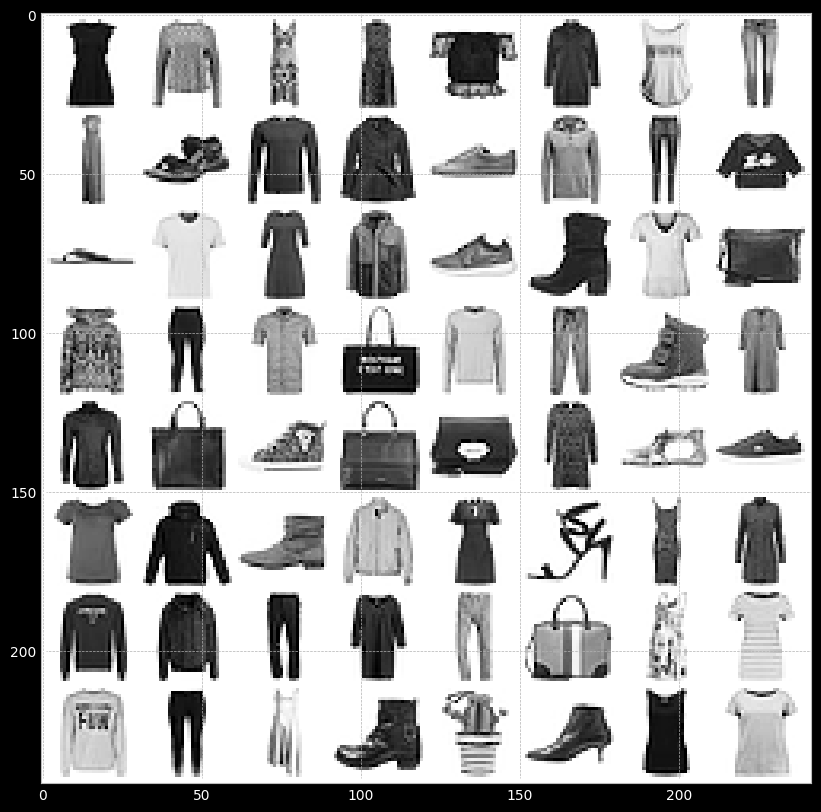

In [8]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

        
# show images
matplotlib_imshow(img_grid, one_channel=True)

In [9]:
# write to tensorboard
writer.add_image("fashion_mnist_images", img_grid)

In [10]:
# Initialize model
# model = M.NeuralNetwork(c, dx1, dx2, num_classes)
# model = M.ResNet(1, 18, M.ResidualBlock, num_classes=num_classes)
# model = M.TinyResnet(c, M.ResidualBlock, num_classes=num_classes)
model = M.TinyResnetV2(c, M.ResidualBlock, num_classes=num_classes)
model = model.to(device)
print(model)

TinyResnetV2(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 

In [11]:
# Optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [12]:
# Inspect model using Tensorboard
writer.add_graph(model, images)

In [13]:
checkpoint_dir = os.path.join(MODEL_DIR, "fashion-mnist")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, f"{MODEL_SUFFIX}.pth")

T.fit(
    model, 
    train_dataloader, 
    test_dataloader, 
    loss_fn, 
    optimizer, 
    n_epochs=EPOCHS, 
    checkpoint_path=checkpoint_path, 
    writer=writer
)
 
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 938/938 [00:57<00:00, 16.39batch/s, loss=0.348]


Test Performance: 
 Accuracy: 72.87%, Avg loss: 0.7387 

Test Performance: 
 Accuracy: 72.03%, Avg loss: 0.7672 

Elapsed time: 57.19 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 2
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.50batch/s, loss=0.36] 


Test Performance: 
 Accuracy: 83.55%, Avg loss: 0.4640 

Test Performance: 
 Accuracy: 82.40%, Avg loss: 0.4960 

Elapsed time: 56.85 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 3
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.49batch/s, loss=0.464]


Test Performance: 
 Accuracy: 84.95%, Avg loss: 0.3990 

Test Performance: 
 Accuracy: 83.89%, Avg loss: 0.4374 

Elapsed time: 56.90 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 4
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.57batch/s, loss=0.41]  


Test Performance: 
 Accuracy: 87.33%, Avg loss: 0.3415 

Test Performance: 
 Accuracy: 85.69%, Avg loss: 0.3938 

Elapsed time: 56.62 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 5
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.57batch/s, loss=0.0868]


Test Performance: 
 Accuracy: 87.91%, Avg loss: 0.3105 

Test Performance: 
 Accuracy: 86.23%, Avg loss: 0.3666 

Elapsed time: 56.62 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 6
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.58batch/s, loss=0.166]


Test Performance: 
 Accuracy: 90.83%, Avg loss: 0.2491 

Test Performance: 
 Accuracy: 88.72%, Avg loss: 0.3097 

Elapsed time: 56.58 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 7
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.51batch/s, loss=0.502] 


Test Performance: 
 Accuracy: 90.49%, Avg loss: 0.2612 

Test Performance: 
 Accuracy: 88.49%, Avg loss: 0.3247 

Elapsed time: 56.81 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 8
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.58batch/s, loss=0.144] 


Test Performance: 
 Accuracy: 91.17%, Avg loss: 0.2398 

Test Performance: 
 Accuracy: 88.51%, Avg loss: 0.3092 

Elapsed time: 56.58 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 9
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.59batch/s, loss=0.119] 


Test Performance: 
 Accuracy: 92.41%, Avg loss: 0.2080 

Test Performance: 
 Accuracy: 89.54%, Avg loss: 0.2838 

Elapsed time: 56.56 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 10
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.56batch/s, loss=0.0829]


Test Performance: 
 Accuracy: 87.00%, Avg loss: 0.3782 

Test Performance: 
 Accuracy: 84.52%, Avg loss: 0.4702 

Elapsed time: 56.66 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 11
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.51batch/s, loss=0.226] 


Test Performance: 
 Accuracy: 92.44%, Avg loss: 0.2027 

Test Performance: 
 Accuracy: 89.58%, Avg loss: 0.2930 

Elapsed time: 56.80 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 12
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.58batch/s, loss=0.199] 


Test Performance: 
 Accuracy: 91.86%, Avg loss: 0.2157 

Test Performance: 
 Accuracy: 88.94%, Avg loss: 0.3195 

Elapsed time: 56.57 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 13
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.48batch/s, loss=0.103] 


Test Performance: 
 Accuracy: 92.41%, Avg loss: 0.1994 

Test Performance: 
 Accuracy: 88.85%, Avg loss: 0.3023 

Elapsed time: 56.91 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 14
-------------------------------


100%|██████████| 938/938 [00:57<00:00, 16.45batch/s, loss=0.096] 


Test Performance: 
 Accuracy: 93.09%, Avg loss: 0.1849 

Test Performance: 
 Accuracy: 89.40%, Avg loss: 0.2968 

Elapsed time: 57.01 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 15
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.47batch/s, loss=0.232] 


Test Performance: 
 Accuracy: 92.72%, Avg loss: 0.1947 

Test Performance: 
 Accuracy: 88.98%, Avg loss: 0.3080 

Elapsed time: 56.95 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 16
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.49batch/s, loss=0.0493]


Test Performance: 
 Accuracy: 93.31%, Avg loss: 0.1770 

Test Performance: 
 Accuracy: 89.25%, Avg loss: 0.3000 

Elapsed time: 56.87 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 17
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.54batch/s, loss=0.124] 


Test Performance: 
 Accuracy: 94.04%, Avg loss: 0.1614 

Test Performance: 
 Accuracy: 89.61%, Avg loss: 0.3009 

Elapsed time: 56.71 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 18
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.53batch/s, loss=0.185] 


Test Performance: 
 Accuracy: 94.95%, Avg loss: 0.1400 

Test Performance: 
 Accuracy: 90.46%, Avg loss: 0.2804 

Elapsed time: 56.74 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 19
-------------------------------


100%|██████████| 938/938 [00:57<00:00, 16.44batch/s, loss=0.167] 


Test Performance: 
 Accuracy: 95.30%, Avg loss: 0.1264 

Test Performance: 
 Accuracy: 90.20%, Avg loss: 0.2878 

Elapsed time: 57.07 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 20
-------------------------------


100%|██████████| 938/938 [00:58<00:00, 15.96batch/s, loss=0.0861]


Test Performance: 
 Accuracy: 94.28%, Avg loss: 0.1503 

Test Performance: 
 Accuracy: 89.49%, Avg loss: 0.3228 

Elapsed time: 58.79 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 21
-------------------------------


100%|██████████| 938/938 [00:57<00:00, 16.22batch/s, loss=0.111] 


Test Performance: 
 Accuracy: 94.95%, Avg loss: 0.1385 

Test Performance: 
 Accuracy: 89.62%, Avg loss: 0.3077 

Elapsed time: 57.85 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 22
-------------------------------


100%|██████████| 938/938 [00:56<00:00, 16.51batch/s, loss=0.0361]


Test Performance: 
 Accuracy: 96.10%, Avg loss: 0.1074 

Test Performance: 
 Accuracy: 90.29%, Avg loss: 0.3082 

Elapsed time: 56.83 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 23
-------------------------------


100%|██████████| 938/938 [00:59<00:00, 15.84batch/s, loss=0.0763]


Test Performance: 
 Accuracy: 95.94%, Avg loss: 0.1101 

Test Performance: 
 Accuracy: 89.86%, Avg loss: 0.3135 

Elapsed time: 59.22 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 24
-------------------------------


100%|██████████| 938/938 [01:02<00:00, 14.94batch/s, loss=0.414] 


Test Performance: 
 Accuracy: 94.36%, Avg loss: 0.1494 

Test Performance: 
 Accuracy: 89.48%, Avg loss: 0.3609 

Elapsed time: 62.80 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Epoch 25
-------------------------------


100%|██████████| 938/938 [00:58<00:00, 16.12batch/s, loss=0.0239]


Test Performance: 
 Accuracy: 96.60%, Avg loss: 0.0949 

Test Performance: 
 Accuracy: 89.99%, Avg loss: 0.3262 

Elapsed time: 58.19 seconds

Saved PyTorch Model State to models/fashion-mnist/tinyresnet-exp2.pth
Done!
